In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import optimize

# Environment Setup

In [2]:
class NonStationaryStochasticPricingEnvironment:
    """
    Non-Stationary stochastic environment, with the distribution over customer valuations for a single product changing quickly over time.
    """
    def __init__(self, valuation_distributions, prices, demand_noise_std=0.1):
        """
        Args:
            valuation_distributions: A list of different scipy.stats distributions representing customer valuations
            demand_noise_std: Standard deviation of noise in demand probability
            current_round: Variable that keep the count of the round been played.
        """
        self.valuation_dist = valuation_distributions
        self.noise_std = demand_noise_std
        self.current_round = 0
        self.prices = prices


    def demand_probability(self, price):
        """
        Calculate the probability that a customer buys at given price.
        This is P(valuation >= price) with some noise.
        """
        # Retrieve the distribution associated with the current round
        current_dist = self.valuation_dist[self.current_round]

        # Base probability: customers buy if their valuation >= price
        base_prob = 1 - current_dist.cdf(price)
        
        # Add some noise to make it stochastic
        noise = np.random.normal(0, self.noise_std)
        
        prob = base_prob + noise
        # Ensure probability is in [0, 1]
        return np.clip(prob, 0, 1)
    

    def simulate_round(self, price):
        
        """
        Simulate one pricing round.
        Returns: (sale_made, revenue)
        """

        # Retrieve the distribution associated with the current round
        current_dist = self.valuation_dist[self.current_round]

        # Draw a random customer valuation from the distribution
        valuation = current_dist.rvs()
        
        # Customer purchases if their valuation >= price
        sale_made = 1 if valuation >= price else 0
        
        # Revenue is price if sale was made, 0 otherwise
        revenue = sale_made * price
        
        sale_made_full = valuation>=self.prices
        revenue_full = self.prices * sale_made_full
        
        # Updating rounds' count
        self.current_round += 1

        return sale_made, revenue, sale_made_full, revenue_full

Poi quando vado a definire l'env conf, definisco una funzione lambda per media e std. Creo un vettore di distribuzioni da passare all'environment.
Forse addirittura ha senso cambiare la distribuzione (e non farle solo normale), per creare un cambiamento più sharp.

# Agent

In [3]:
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K, dtype = float)
        self.x_t = np.ones(K, dtype = float)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t
    
    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1

In [4]:
class PrimalDualAgent:
    def __init__(self, prices, valuation, P, T, eta):
        self.prices = prices
        self.K = len(prices)
        self.hedge = HedgeAgent(self.K, np.sqrt(np.log(self.K)/T))
        self.valuation = valuation
        self.P = P  #Budget
        self.eta = eta
        self.T = T
        self.rho = self.P/self.T
        self.lmbd = 1
        self.t = 0
        self.N_pulls = np.zeros(len(prices))
        self.bid_index = 0
        self.reward = np.zeros(self.K)
        self.t = 0

        # Inventory management
        self.remaining_inventory = P     # Current remaining inventory

        # History tracking
        self.history = {
            'prices': [],     # Selected prices over time
            'rewards': [],    # Observed revenues over time
            'purchases': [],  # Purchase indicators over time
            'inventory': []   # Inventory levels over time
        }

    def bid(self):
        if self.remaining_inventory < 1:
            self.bid_index = 0
            return 0
        self.bid_index = self.hedge.pull_arm()
        return self.prices[self.bid_index]
    
    def update(self, f_t, c_t, f_t_full, c_t_full):
        # update hedge
        #purchase = (self.valuation[self.t] >= np.array(self.prices)).astype(float)
        #f_t_full = self.prices * purchase
        #c_t_full = purchase
        L = f_t_full - self.lmbd*(c_t_full-self.rho)
        
        L_up = 1 -(1/self.rho)*(1-self.rho)  ### ATTENZIONE, CHECK -self.rho SE CI SONO PROBLEMI
        L_low = 0 -(1/self.rho)*(1-self.rho)
        rescaled_L = (L - L_low)/(L_up-L_low)
        self.hedge.update(1 -rescaled_L) # we need to maximize L

        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), 
                            a_min=0, a_max=1/self.rho)
        # update budget
        self.remaining_inventory -= c_t
        # log
        self.N_pulls[self.bid_index] += 1

        self.reward += f_t_full

        # Record history
        self.history['prices'].append(self.prices[self.bid_index])
        self.history['rewards'].append(f_t)
        self.history['purchases'].append(c_t)
        self.history['inventory'].append(self.remaining_inventory)

        self.t += 1
    
    # For clairvoyant purpose
    #def update_reward(self, f_t_full):
    #    self.reward += f_t_full
    
    # Getter for reward vector
    def get_reward(self):
        return self.reward
    
    # Getter for the index (price) associated with the highest reward
    def get_argmax_reward(self):
        return np.argmax(self.reward)
    
    def get_max_reward(self):
        best_idx = np.argmax(self.reward)
        return self.reward[best_idx]

# Simulation

In [5]:
def run_simulator(
    T,
    valuation_dist,
    env_config,
    agent_params,
    n_simulations=3,
    verbose=True
):
    selected_prices = []
    revenues = []
    sales = []
    cumulative_revenue = []
    total_revenue = 0
    best_price = []
    best_reward = []
    best_reward_value = 0
    best_price_value = 0
    first_inventory_empty = None

    # === Compute theoretical optimum once before all simulations ===
    env_theoretical = NonStationaryStochasticPricingEnvironment(
        valuation_distributions=valuation_dist,
        prices=agent_params['prices']
    )
    """
    opt_dist, opt_value, true_purchase_probs, true_rewards = compute_clairvoyant(
        prices=agent_params['prices'],
        environment=env_theoretical,
        T=agent_params['T'],
        P=agent_params['P']
    )
    optimal_idx = np.argmax(opt_dist)
    #optimal_revenue = np.dot(agent_params['prices'], opt_dist)
    optimal_revenue = np.dot(true_rewards, opt_dist)
    """
    for sim in range(n_simulations):
        
        print(f"\n=== Running Primal-Dual Pricing Simulation #{sim + 1} for {T} rounds ===")

        # Create environment and agent
        env = NonStationaryStochasticPricingEnvironment(
            valuation_distributions=valuation_dist,
            prices = agent_params['prices']
        )
        agent = PrimalDualAgent(**agent_params)
        #agent = ThompsonSamplingAgent(P =agent_params['P'], T=T, prices=agent_params['prices'], rho_penalty=agent_params['rho_penalty'])

        for t in range(T):
            if agent.remaining_inventory < 1 and first_inventory_empty is None:
                first_inventory_empty = t
                print(f"Inventory empty for the first time at round {t}")
                print("No more products in the inventory")

            price = agent.bid()
            price_idx = agent.bid_index

            if agent.remaining_inventory <= 0:
                sale_made = False
                revenue = 0
            else:
                sale_made, revenue, sale_made_full, revenue_full = env.simulate_round(price)

            agent.update(revenue, sale_made, revenue_full, sale_made_full)

            selected_prices.append(price)
            revenues.append(revenue)
            sales.append(sale_made)
            total_revenue += revenue
            cumulative_revenue.append(total_revenue)

        best_reward_value = agent.get_max_reward()
        best_reward = np.append(best_reward, best_reward_value)
        best_price_value = agent_params['prices'][agent.get_argmax_reward()]
        best_price = np.append(best_price, best_price_value)

        print(f"\nSimulation completed!")
        print(f"Total revenue: {total_revenue:.2f}")
        print(f"Average revenue per round: {total_revenue / T:.2f}")
        print(f"Agent's best price: {best_price[-1]}")
        #print(f"Theoretical optimal: {opt_dist} (expected revenue: {optimal_revenue:.2f})")

    #price_to_idx = {p: i for i, p in enumerate(agent_params['prices'])}
    #price_indices = [price_to_idx[p] for p in selected_prices if not np.isnan(p)]
    #price_counts = np.bincount(price_indices, minlength=len(agent_params['prices']))        

    #if verbose:
        #print("\n=== Simulation Results ===")
        #print("\nPrice selection frequency:")
        #for i, (price, count) in enumerate(zip(agent_params['prices'], price_counts)):
            #percentage = 100 * count / T
            #marker = " ← OPTIMAL" if i == optimal_idx else ""
            #print(f"  Price {price:2}: {count:4d} times ({percentage:5.1f}%){marker}")

    return {
        #'price_counts': price_counts,
        'selected_prices': selected_prices,
        'revenues': revenues,
        'sales': sales,
        'cumulative_revenue': cumulative_revenue,
        'best_price': best_price,
        'best_reward': best_reward,
        'first_inventory_empty': first_inventory_empty,
        'total_revenue': total_revenue,
        #'opt_dist': opt_dist,
        #'optimal_idx': optimal_idx,
        #'optimal_revenue': optimal_revenue,
        'agent': agent  # Add the final agent state
    }

In [31]:
np.append(np.array([1,2,3]), [4,5])

array([1, 2, 3, 4, 5])

RUN THE SIMULATION

In [7]:
# ===== Configurazione Ambiente Non Stazionario =====
env_config = {
    'valuation_mean': 0.5,  # Average customer valuation
    'valuation_std': 0.05,   # Standard deviation of customer valuations
    'demand_noise_std': 0.005  # Noise in demand probability
}

T = 10000 # Number of rounds
means = np.random.uniform(0, 1, size=T)
stds = np.random.uniform(0, 0.1, size=T)


####### Non riesco a creare un array di distribuzioni, domani cerco di samplare media e std direttamente dall'env #######
valuation_dists = [
    stats.norm(
        loc=means[_],
        scale=stds[_]
    )
    for _ in range(T)
]

inventory = int(T * 0.1)       # Initial inventory
eta = 0.1                      # Learning rate for lambda

# ===== Inizializza Agente e Ambiente =====
agent_params = {
    'prices': np.arange(0.1, 0.9, 1/7),  # set of prices 
    'valuation' : valuation_dists,
    'P': inventory,  # inventory constraint
    'T': T,  # number of rounds
    'eta': eta,
}

agent = PrimalDualAgent(**agent_params)

env = NonStationaryStochasticPricingEnvironment(valuation_dists, agent_params['prices'])

#print(f"Customer valuation distribution: Normal(μ={env_config['valuation_mean']}, σ={env_config['valuation_std']})")
print(f"Number of price options: {len(agent_params['prices'])}")
print(f'Inventory contrain: ',agent_params['P'])
print(f'Number of rounds:',agent_params['T'])

# set random seed for reproducibility
np.random.seed(42)

results = run_simulator(
    T=T,
    valuation_dist=valuation_dists,
    env_config=env_config,
    agent_params=agent_params,
    n_simulations=1,
    verbose=True
)

selected_prices = results['selected_prices']
revenues = results['revenues']
sales = results['sales']
cumulative_revenue = results['cumulative_revenue']
best_price = results['best_price']
first_inventory_empty = results['first_inventory_empty']
total_revenue = results['total_revenue']
best_reward = results['best_reward']
#price_counts = results['price_counts']
agent = results['agent']  # Get the actual agent used in simulation

Number of price options: 6
Inventory contrain:  1000
Number of rounds: 10000

=== Running Primal-Dual Pricing Simulation #1 for 10000 rounds ===
Inventory empty for the first time at round 5066
No more products in the inventory

Simulation completed!
Total revenue: 788.29
Average revenue per round: 0.08
Agent's best price: 0.8142857142857142


C:\Users\Federico\AppData\Local\Temp\ipykernel_37428\1165309617.py:16: RuntimeWarning: overflow encountered in multiply
  self.weights *= np.exp(-self.learning_rate*l_t)


PLOT

In [9]:
def compute_theoretical_optimum(agent_params, valuation_dist, T):
    """
    Compute theoretical optimum for non-stationary environment.
    Since environment changes every round, compute expected optimal revenue per round.
    """
    prices = agent_params['prices']
    opt_revenues_per_round = []
    
    for t in range(T):
        current_dist = valuation_dist[t]
        # For each price, compute expected revenue = price * P(valuation >= price)
        expected_revenues = []
        for price in prices:
            prob_purchase = 1 - current_dist.cdf(price)
            expected_revenue = price * prob_purchase
            expected_revenues.append(expected_revenue)
        
        # Best expected revenue for this round
        best_revenue = max(expected_revenues)
        best_idx = np.argmax(expected_revenues)
        opt_revenues_per_round.append((best_revenue, best_idx))
    
    # Average optimal policy (approximate)
    opt_revenues = [x[0] for x in opt_revenues_per_round]
    opt_indices = [x[1] for x in opt_revenues_per_round]
    
    # Compute average optimal distribution
    opt_dist = np.zeros(len(prices))
    for idx in opt_indices:
        opt_dist[idx] += 1
    opt_dist = opt_dist / T
    
    optimal_revenue = np.mean(opt_revenues)
    
    return opt_dist, optimal_revenue, opt_revenues, opt_indices

def plot_results(T, revenues, cumulative_revenue, selected_prices, 
                 agent_params, sales, agent, valuation_dist, env_config):
    """
    Generate comprehensive visualizations and analysis of the Primal-Dual pricing algorithm.
    Adapted from UCB plotting code for primal-dual algorithm.
    """
    
    # === Theoretical Analysis ===
    print('=== Theoretical Analysis ===')

    opt_dist, optimal_revenue, true_rewards, opt_indices = compute_theoretical_optimum(
        agent_params, valuation_dist, T
    )

    prices = agent_params['prices']
    optimal_idx = np.argmax(opt_dist)
    
    print("Optimal price distribution (average over time):")
    for i in range(len(prices)):
        marker = " ← MOST FREQUENT OPTIMAL" if i == optimal_idx else ""
        print(f"  Price {prices[i]:2f}: p = {opt_dist[i]:5.3f}{marker}")

    print(f'\n=== Optimal Expected Revenue Per Round === \n         {optimal_revenue:.2f}')

    # === Performance Analysis ===
    theoretical_optimal_total = optimal_revenue * T
    total_revenue = sum(revenues)
    actual_regret = theoretical_optimal_total - total_revenue
    
    # Regret calculation for non-stationary environment
    regret_per_round = []
    for t in range(T):
        # Instantaneous regret = optimal_revenue_at_t - actual_revenue_at_t
        optimal_at_t = true_rewards[t]
        instantaneous_regret = max(0, optimal_at_t - revenues[t])
        regret_per_round.append(instantaneous_regret)
    
    regret_cumulative = np.cumsum(regret_per_round)

    # Price counts
    price_to_idx = {p: i for i, p in enumerate(agent_params['prices'])}
    price_indices = []
    for p in selected_prices:
        if not np.isnan(p) and p in price_to_idx:
            price_indices.append(price_to_idx[p])
    
    if price_indices:
        price_counts = np.bincount(price_indices, minlength=len(agent_params['prices']))
    else:
        price_counts = np.zeros(len(agent_params['prices']))

    # === Enhanced Visualization ===
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # 1. Cumulative Revenue vs Optimal (clearer formatting)
    axes[0, 0].plot(cumulative_revenue, label='Primal-Dual Agent Revenue', linewidth=3, color='blue', alpha=0.8)
    axes[0, 0].plot([optimal_revenue * (t+1) for t in range(T)], 
                    label='Theoretical Optimal', linestyle='--', linewidth=3, color='red', alpha=0.8)
    
    # Add performance percentage
    final_performance = (total_revenue / (optimal_revenue * T)) * 100
    axes[0, 0].text(0.02, 0.98, f'Agent Performance: {final_performance:.1f}%\nof Theoretical Optimal', 
                    transform=axes[0, 0].transAxes, fontsize=11, va='top',
                    bbox=dict(boxstyle="round,pad=0.4", facecolor="yellow", alpha=0.7))
    
    axes[0, 0].set_xlabel('Round', fontsize=12)
    axes[0, 0].set_ylabel('Cumulative Revenue', fontsize=12)
    axes[0, 0].set_title('Revenue Performance Comparison', fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Regret Analysis (improved with primal-dual bounds)
    t_vals = np.arange(1, T + 1)
    axes[0, 1].plot(regret_cumulative, color='red', linewidth=3, label='Actual Cumulative Regret', alpha=0.8)
    
    # Primal-dual theoretical bound: O(√T log T) for inventory-constrained online learning
    K = len(agent_params['prices'])
    P = agent_params['P']  # Inventory constraint
    OPT_per_round = optimal_revenue
    
    # Primal-dual bound: O(√T log T * OPT)
    sqrt_t_log_t = np.sqrt(t_vals) * np.log(t_vals + 1)
    primal_dual_bound = OPT_per_round * sqrt_t_log_t * 0.5  # Scale factor
    
    axes[0, 1].plot(t_vals, primal_dual_bound, '--', color='blue', alpha=0.7, linewidth=2,
                   label='Primal-Dual Bound O(√T log T)')
    
    # Add regret growth info
    final_regret_rate = regret_cumulative[-1] / T
    axes[0, 1].text(0.02, 0.98, f'Final Regret Rate: {final_regret_rate:.4f}\nPrimal-Dual with Inventory', 
                    transform=axes[0, 1].transAxes, fontsize=11, va='top',
                    bbox=dict(boxstyle="round,pad=0.4", facecolor="lightgreen", alpha=0.7))
    
    axes[0, 1].set_xlabel('Round', fontsize=12)
    axes[0, 1].set_ylabel('Cumulative Regret', fontsize=12)
    axes[0, 1].set_title('Regret Growth Analysis', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Policy Comparison (optimal vs learned)
    agent_dist = price_counts / max(T, 1)  # Avoid division by zero
    x_pos = np.arange(len(prices))
    width = 0.35
    
    bars1 = axes[0, 2].bar(x_pos - width/2, opt_dist, width, label='Optimal Policy', 
                          color='green', alpha=0.7)
    bars2 = axes[0, 2].bar(x_pos + width/2, agent_dist, width, label='Learned Policy', 
                          color='blue', alpha=0.7)
    
    # Highlight most used prices
    for i, (opt_prob, agent_prob) in enumerate(zip(opt_dist, agent_dist)):
        if opt_prob > 0.05:
            axes[0, 2].text(i - width/2, opt_prob + 0.02, f'{opt_prob:.2f}', 
                           ha='center', va='bottom', fontsize=9, fontweight='bold')
        if agent_prob > 0.05:
            axes[0, 2].text(i + width/2, agent_prob + 0.02, f'{agent_prob:.2f}', 
                           ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    axes[0, 2].set_xlabel('Price', fontsize=12)
    axes[0, 2].set_ylabel('Selection Probability', fontsize=12)
    axes[0, 2].set_title('Policy Comparison: Optimal vs Learned', fontsize=14, fontweight='bold')
    axes[0, 2].set_xticks(x_pos)
    axes[0, 2].set_xticklabels([f'{p:.2f}' for p in prices], rotation=45)
    axes[0, 2].legend(fontsize=11)
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Price Selection Frequency (improved)
    colors = ['lightcoral' if i == optimal_idx else 'skyblue' for i in range(len(prices))]
    bars = axes[1, 0].bar(prices, price_counts, alpha=0.8, color=colors, edgecolor='black', linewidth=1)
    
    # Add optimal policy overlay
    optimal_counts = opt_dist * T
    axes[1, 0].plot(prices, optimal_counts, 'ro-', linewidth=3, markersize=8, 
                   label='Optimal Distribution', alpha=0.8)
    
    # Improved labels
    for i, (bar, count) in enumerate(zip(bars, price_counts)):
        if count > 50:  # Only label significant bars
            percentage = 100 * count / max(T, 1)
            axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + T*0.01,
                           f'{percentage:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    axes[1, 0].set_xlabel('Price', fontsize=12)
    axes[1, 0].set_ylabel('Selection Count', fontsize=12)
    axes[1, 0].set_title('Price Selection vs Optimal Target', fontsize=14, fontweight='bold')
    axes[1, 0].legend(fontsize=11)
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Revenue Convergence Analysis (improved)
    window_size = min(100, T // 20)  # Larger window for smoother curve
    if window_size > 1:
        moving_avg = np.convolve(revenues, np.ones(window_size)/window_size, mode='valid')
        axes[1, 1].plot(range(window_size-1, T), moving_avg, linewidth=3, 
                       label=f'Revenue (MA-{window_size})', color='blue', alpha=0.8)
    else:
        axes[1, 1].plot(revenues, linewidth=1, alpha=0.7, 
                       label='Revenue per Round', color='blue')
        
    axes[1, 1].axhline(optimal_revenue, color='red', linestyle='--', linewidth=3,
                       label=f'Optimal ({optimal_revenue:.2f})', alpha=0.8)
    
    # Add convergence zones
    axes[1, 1].axhspan(optimal_revenue * 0.9, optimal_revenue * 1.1, alpha=0.1, color='green',
                      label='±10% of Optimal')
    
    # Performance indicator
    recent_avg = np.mean(revenues[-1000:]) if T > 1000 else np.mean(revenues)
    convergence_pct = (recent_avg / optimal_revenue) * 100
    axes[1, 1].text(0.02, 0.98, f'Recent Avg Revenue: {recent_avg:.2f}\nConvergence: {convergence_pct:.1f}%', 
                    transform=axes[1, 1].transAxes, fontsize=11, va='top',
                    bbox=dict(boxstyle="round,pad=0.4", facecolor="lightblue", alpha=0.7))
    
    axes[1, 1].set_xlabel('Round', fontsize=12)
    axes[1, 1].set_ylabel('Revenue per Round', fontsize=12)
    axes[1, 1].set_title('Revenue Convergence Analysis', fontsize=14, fontweight='bold')
    axes[1, 1].legend(fontsize=11)
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Inventory and Constraint Analysis 
    inventory_levels = [agent_params['P'] - sum(sales[:i]) for i in range(T)]
    required_rate = [max(0, inv/(T-t)) if t < T else 0 for t, inv in enumerate(inventory_levels)]
    
    axes[1, 2].plot(inventory_levels, label='Remaining Inventory', linewidth=3, color='orange', alpha=0.8)
    axes[1, 2].set_ylabel('Inventory Level', fontsize=12, color='orange')
    axes[1, 2].tick_params(axis='y', labelcolor='orange')
    
    # Add constraint requirement on second y-axis
    ax2 = axes[1, 2].twinx()
    ax2.plot(required_rate, label='Required Sell Rate', linewidth=2, color='purple', alpha=0.7, linestyle='--')
    ax2.axhline(agent_params['P']/T, color='red', linestyle=':', linewidth=2, alpha=0.7,
               label=f'Target Rate ({agent_params["P"]/T:.3f})')
    ax2.set_ylabel('Required Rate', fontsize=12, color='purple')
    ax2.tick_params(axis='y', labelcolor='purple')
    
    # Final statistics
    utilization = ((agent_params['P'] - agent.remaining_inventory) / agent_params['P']) * 100
    axes[1, 2].text(0.02, 0.98, f'Inventory Utilization: {utilization:.1f}%\nSales Rate: {(sum(sales)/T)*100:.1f}%', 
                    transform=axes[1, 2].transAxes, fontsize=11, va='top',
                    bbox=dict(boxstyle="round,pad=0.4", facecolor="lightyellow", alpha=0.7))
    
    axes[1, 2].set_xlabel('Round', fontsize=12)
    axes[1, 2].set_title('Inventory & Constraint Management', fontsize=14, fontweight='bold')
    axes[1, 2].grid(True, alpha=0.3)
    
    # Combine legends
    lines1, labels1 = axes[1, 2].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    axes[1, 2].legend(lines1 + lines2, labels1 + labels2, loc='center right', fontsize=10)

    plt.tight_layout()
    plt.show()

    # === Enhanced Average Regret Analysis ===
    t_vals = np.arange(1, T + 1)
    regret_avg = np.array(regret_cumulative) / t_vals

    plt.figure(figsize=(14, 8))
    
    # Create subplot for better layout
    gs = plt.GridSpec(2, 2, height_ratios=[2, 1], width_ratios=[3, 1])
    
    # Main regret plot
    ax1 = plt.subplot(gs[0, :])
    ax1.plot(t_vals, regret_avg, label=r'$R(t)/t$ (Average Regret)', linewidth=3, color='blue', alpha=0.8)
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Zero Regret')
    
    # Add theoretical convergence line
    theoretical_limit = regret_avg[-1000:].mean() if T > 1000 else regret_avg[-1]
    ax1.axhline(y=theoretical_limit, color='green', linestyle=':', alpha=0.7, linewidth=2,
               label=f'Steady State ≈ {theoretical_limit:.4f}')
    
    # Highlight convergence region
    convergence_start = T // 2
    ax1.axvspan(convergence_start, T, alpha=0.1, color='green', label='Convergence Region')
    
    # Add annotations
    ax1.text(0.02, 0.98, 
            f'Final Regret Rate: {regret_avg[-1]:.4f}\n'
            f'Primal-Dual: O(√T log T)\n'
            f'Per-round rate: O((log T)/√T)\n'
            f'Non-stationary environment', 
            transform=ax1.transAxes, fontsize=12, va='top',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8))
    
    # Add explanation box
    ax1.text(0.98, 0.98,
            'Primal-Dual with Inventory:\n'
            '• Regret: O(√T log T)\n'
            '• Handles non-stationarity\n'
            '• Constraint satisfaction\n'
            '• Lagrange multiplier adaptation',
            transform=ax1.transAxes, fontsize=11, va='top', ha='right',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))
    
    ax1.set_xlabel('Round', fontsize=14)
    ax1.set_ylabel('Average Regret per Round', fontsize=14)
    ax1.set_title('Average Regret Convergence Analysis (Primal-Dual Algorithm)\n(Non-Stationary Environment with Inventory Constraints)', 
                 fontsize=16, fontweight='bold')
    ax1.legend(fontsize=12, loc='center left')
    ax1.grid(True, alpha=0.3)
    
    # Zoomed view of final portion
    ax2 = plt.subplot(gs[1, 0])
    final_portion = max(1000, T//10)
    ax2.plot(t_vals[-final_portion:], regret_avg[-final_portion:], linewidth=3, color='blue', alpha=0.8)
    ax2.axhline(y=theoretical_limit, color='green', linestyle=':', alpha=0.7, linewidth=2)
    ax2.set_xlabel('Round (Final Portion)', fontsize=12)
    ax2.set_ylabel('Average Regret', fontsize=12)
    ax2.set_title('Convergence Detail', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Distribution comparison
    ax3 = plt.subplot(gs[1, 1])
    learned_dist = price_counts / max(T, 1)
    comparison_data = []
    price_labels = []
    
    for i, price in enumerate(prices):
        if opt_dist[i] > 0.01 or learned_dist[i] > 0.01:  # Only show significant prices
            comparison_data.append([opt_dist[i], learned_dist[i]])
            price_labels.append(f'{price:.2f}')
    
    if comparison_data:
        comparison_data = np.array(comparison_data)
        x_pos = np.arange(len(price_labels))
        width = 0.35
        
        ax3.bar(x_pos - width/2, comparison_data[:, 0], width, label='Optimal', alpha=0.7, color='green')
        ax3.bar(x_pos + width/2, comparison_data[:, 1], width, label='Learned', alpha=0.7, color='blue')
        
        ax3.set_ylabel('Probability', fontsize=12)
        ax3.set_title('Policy Mismatch\n(Source of Regret)', fontsize=12, fontweight='bold')
        ax3.set_xticks(x_pos)
        ax3.set_xticklabels(price_labels)
        ax3.legend(fontsize=10)
        ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # === Regret Growth Analysis ===
    try:
        from scipy.stats import linregress
        
        # Fit regret growth in log-log scale
        start_idx = max(len(prices), T//4)
        t_vals_log = np.log(t_vals[start_idx:])  
        regret_vals_to_analyze = np.maximum(regret_cumulative[start_idx:], 1e-6)
        regret_log = np.log(regret_vals_to_analyze)
        
        if len(t_vals_log) > 20:
            slope, intercept, r_value, p_value, std_err = linregress(t_vals_log, regret_log)
            print(f"\n=== Regret Growth Analysis ===")
            print(f"Estimated regret exponent (log-log slope): {slope:.3f}")
            print(f"R-squared: {r_value**2:.3f}")
            
            # Primal-dual theoretical analysis
            K = len(agent_params['prices'])
            P = agent_params['P']
            T_val = T
            
            print(f"Primal-dual regret bound: O(√T log T)")
            print(f"Expected log-log slope: ~0.5 (√T growth)")
            print(f"Algorithm: Primal-Dual with Hedge")
            print(f"Environment: Non-stationary")
            
            if 0.4 < slope < 0.6:
                print(f"✓ Regret growth matches theory (√T)")
            elif slope < 0.4:
                print(f"✓ Better than expected regret growth")
            else:
                print(f"⚠ Regret growth higher than expected")
                
    except Exception as e:
        print(f"Could not perform regret growth analysis: {e}")

    # === Summary Statistics ===
    final_regret = regret_cumulative[-1]
    convergence_rate = 100 * (1 - final_regret/(theoretical_optimal_total))
    sales_rate = 100 * sum(sales) / T
    
    print(f"\n=== Summary Statistics ===")
    print(f"Algorithm: Primal-Dual with Inventory Constraints")
    print(f"Environment: Non-Stationary")
    print(f"Performance rate: {final_performance:.1f}% of optimal")
    print(f"Average revenue per round: {total_revenue/T:.2f}")
    print(f"Revenue std deviation: {np.std(revenues):.2f}")
    print(f"Total sales made: {sum(sales)}")
    print(f"Sales rate: {sales_rate:.1f}%")
    print(f"Remaining inventory: {agent.remaining_inventory}")
    print(f"Total regret: {final_regret:.2f}")
    print(f"Average regret per round: {final_regret/T:.4f}")
    
    # Inventory utilization analysis
    inventory_used = agent_params['P'] - agent.remaining_inventory
    utilization_rate = 100 * inventory_used / agent_params['P']
    print(f"Inventory utilization: {utilization_rate:.1f}%")
    
    # Constraint satisfaction
    target_rate = agent_params['P'] / T
    actual_rate = sum(sales) / T
    constraint_satisfaction = 100 * (1 - abs(actual_rate - target_rate) / target_rate)
    print(f"Constraint satisfaction: {constraint_satisfaction:.1f}%")

    return {
        'cumulative_regret': regret_cumulative,
        'cumulative_revenue': cumulative_revenue,
        'optimal_revenue': optimal_revenue,
        'final_performance': final_performance,
        'sales_rate': sales_rate,
        'inventory_utilization': utilization_rate,
        'constraint_satisfaction': constraint_satisfaction
    }

=== Theoretical Analysis ===
Optimal price distribution (average over time):
  Price 0.100000: p = 0.223 ← MOST FREQUENT OPTIMAL
  Price 0.242857: p = 0.171
  Price 0.385714: p = 0.157
  Price 0.528571: p = 0.156
  Price 0.671429: p = 0.149
  Price 0.814286: p = 0.145

=== Optimal Expected Revenue Per Round === 
         0.39


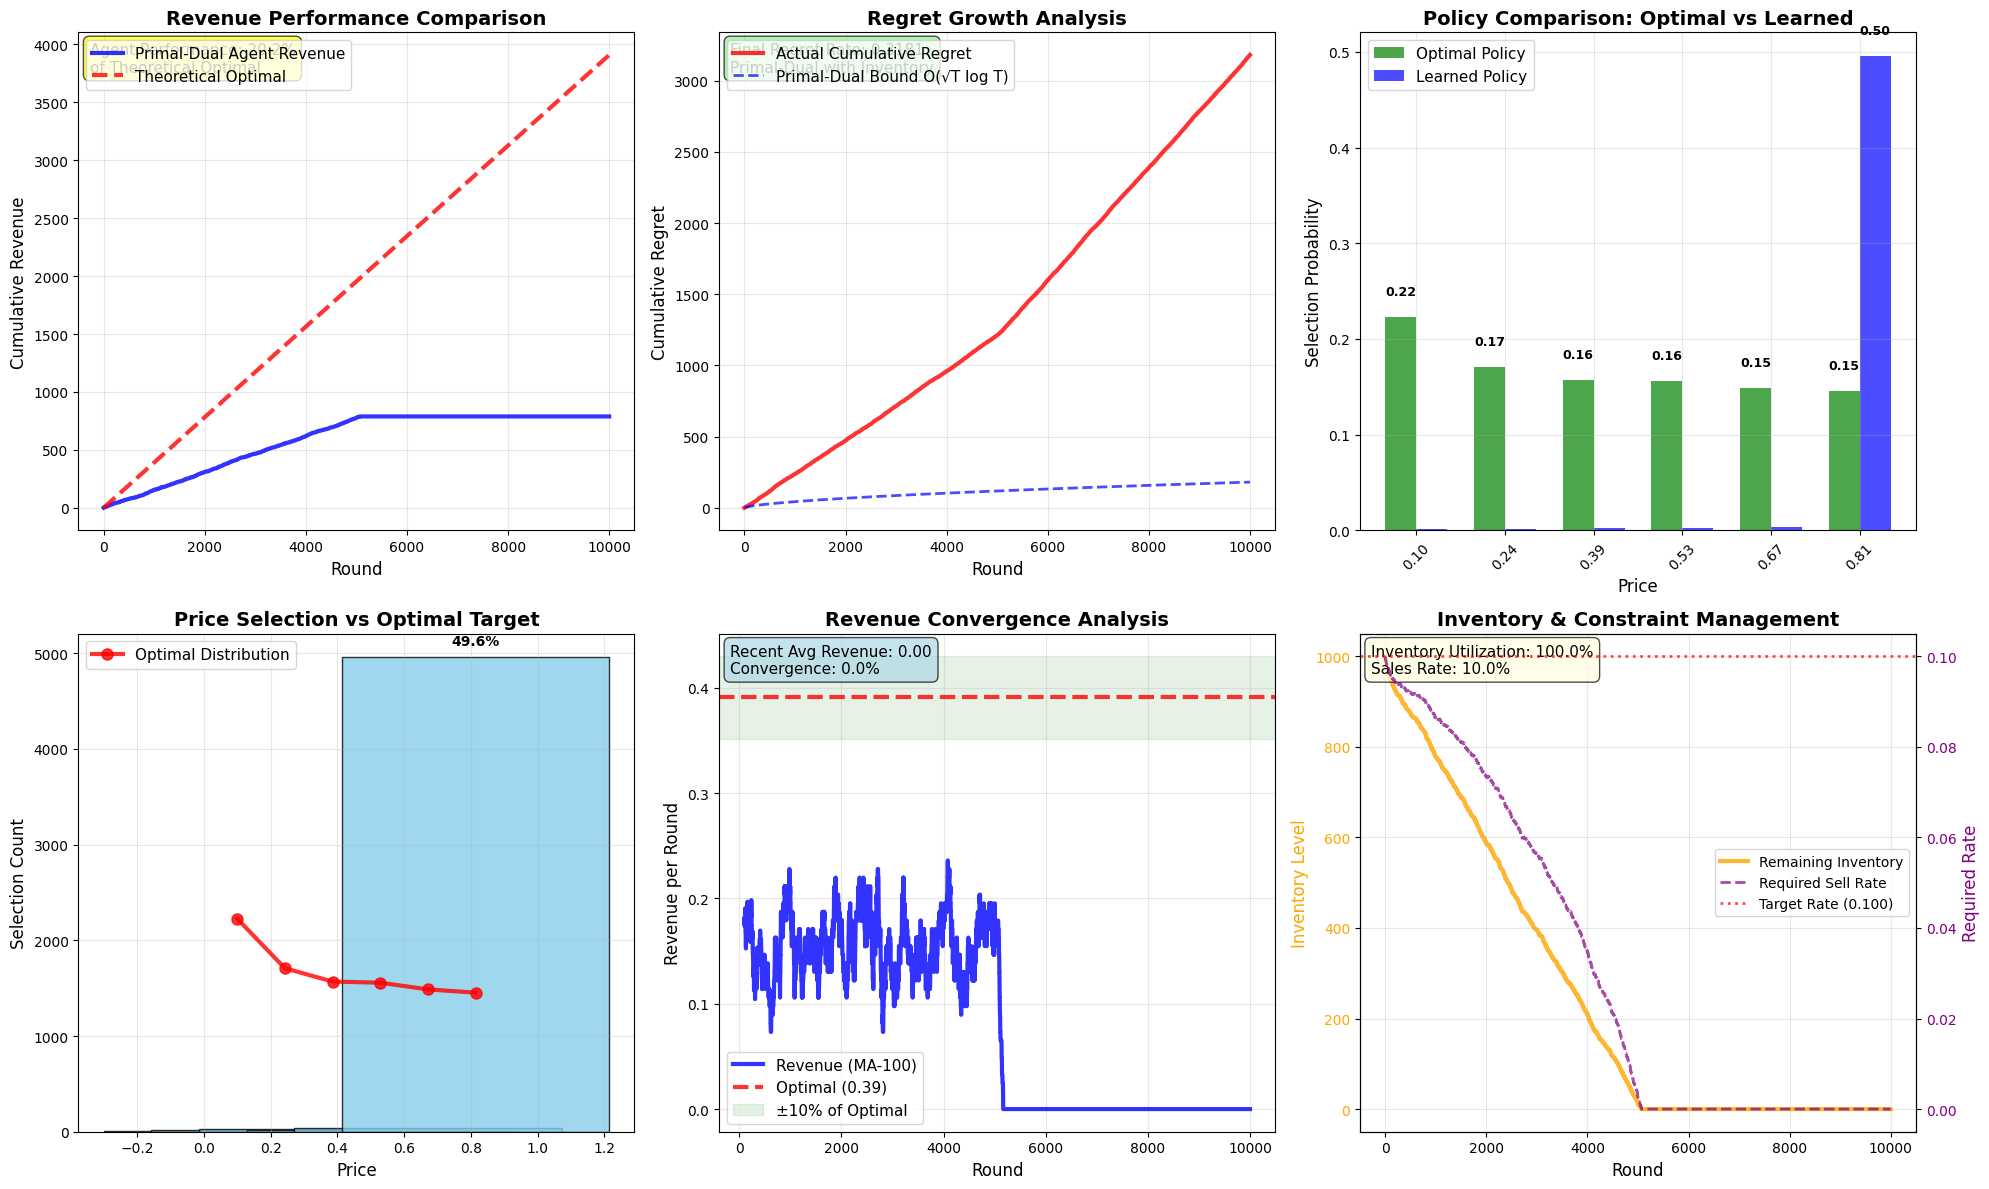

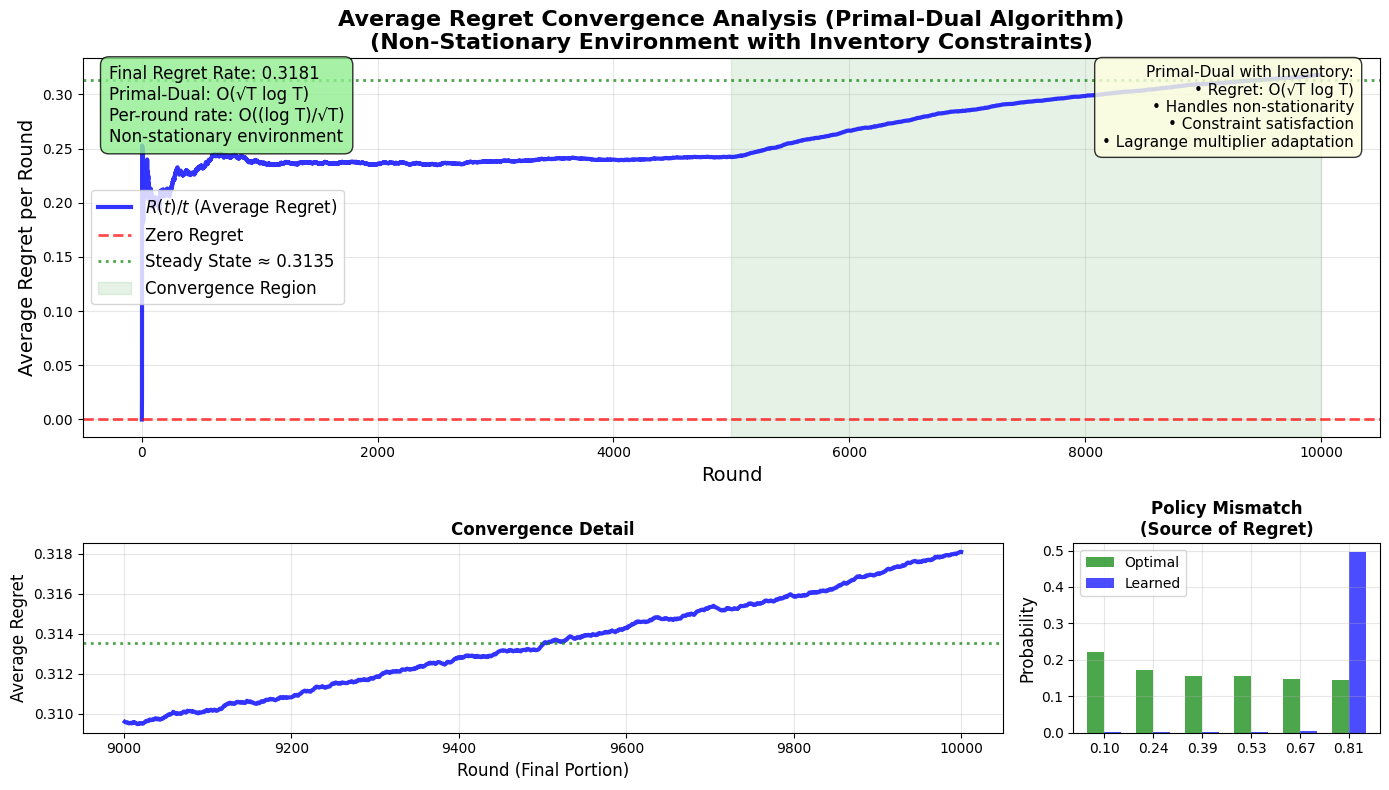


=== Regret Growth Analysis ===
Estimated regret exponent (log-log slope): 1.263
R-squared: 0.995
Primal-dual regret bound: O(√T log T)
Expected log-log slope: ~0.5 (√T growth)
Algorithm: Primal-Dual with Hedge
Environment: Non-stationary
⚠ Regret growth higher than expected

=== Summary Statistics ===
Algorithm: Primal-Dual with Inventory Constraints
Environment: Non-Stationary
Performance rate: 20.2% of optimal
Average revenue per round: 0.08
Revenue std deviation: 0.24
Total sales made: 1000
Sales rate: 10.0%
Remaining inventory: 0
Total regret: 3181.01
Average regret per round: 0.3181
Inventory utilization: 100.0%
Constraint satisfaction: 100.0%


{'cumulative_regret': array([0.00000000e+00, 4.40697180e-02, 7.58355432e-01, ...,
        3.18020321e+03, 3.18076419e+03, 3.18100704e+03]),
 'cumulative_revenue': [0.3857142857142857,
  0.48571428571428565,
  0.5857142857142856,
  1.2571428571428571,
  1.3571428571428572,
  1.6,
  1.842857142857143,
  2.085714285714286,
  2.085714285714286,
  2.085714285714286,
  2.085714285714286,
  2.6142857142857143,
  2.6142857142857143,
  2.857142857142857,
  2.9571428571428573,
  3.0571428571428574,
  3.0571428571428574,
  3.585714285714286,
  3.685714285714286,
  4.357142857142858,
  4.742857142857144,
  4.985714285714287,
  4.985714285714287,
  5.800000000000001,
  5.9,
  6.2857142857142865,
  6.2857142857142865,
  6.814285714285715,
  7.057142857142858,
  7.057142857142858,
  7.057142857142858,
  7.1571428571428575,
  7.1571428571428575,
  7.257142857142857,
  7.257142857142857,
  7.257142857142857,
  7.257142857142857,
  7.257142857142857,
  7.257142857142857,
  7.785714285714286,
  8.3142857

In [10]:
plot_results(
    T=T,
    revenues=results['revenues'],
    cumulative_revenue=results['cumulative_revenue'], 
    selected_prices=results['selected_prices'],
    agent_params=agent_params,
    sales=results['sales'],
    agent=results['agent'],
    valuation_dist=valuation_dists,  # Le tue distribuzioni non stazionarie
    env_config=env_config
)

In [8]:
results['best_reward']

array([4796.95714286])

In [ ]:
"""
class PrimalDualAgent:
    Primal-dual agent for dynamic pricing with inventory constraints in highly non-stationary environments.
    
    This agent implements a primal-dual based algorithm adapted for:
    1. Dynamic pricing (instead of traditional MAB rewards)
    2. Inventory constraints (limited number of products to sell)
    3. Dual optimization: maximize revenue while respecting inventory constraint
    
    The algorithm maintains upper confidence bounds on revenue (f_UCB) and 
    lower confidence bounds on demand probability (c_LCB), then solves a 
    linear program to find the optimal price distribution.
    def __init__(self, P, T, prices, eta = 0.1, ema_alpha = 0.2, lambda0 = 0.0):
        Initialize the UCB agent for constrained dynamic pricing.
        
        Args:
            P: Total inventory (number of products available)
            T: Time horizon (number of rounds)
            prices: List of available prices to choose from
            eta: learning rate for dual update
        k = len(prices)

        # Environment parameters
        self.prices = prices  # Available price options
        self.K = k           # Number of price arms
        self.T = T           # Total number of rounds
        self.t = 0           # Current round number
        
        # Primal-dual parameters
        self.rho = P/float(T)                         # Target selling rate
        self.eta = eta
        self.lambda_ = float(lambda0)
        self.lambda_upper = 1.0 / max(self.rho, 1e-8) # Projection upper bound
        
        # Inventory management
        self.inventory = P  # Initial inventory
        self.remaining_inventory = P # Current remaining inventory 

        # EMA estimates (reactive to non-stationarity)
        self.ema_alpha = ema_alpha
        self.f_est = np.zeros(self.K)        # Estimated expected revenue for each price
        self.c_est = np.ones(self.K) * 1e-6  # Estimated demand probability for each price, initialized with small positive number to avoid degenerate LP constraints
        
        
        self.N_pulls = np.zeros(k)           # Number of times each price was selected
        self.current_price_idx = None

        # History tracking
        self.history = {
            'prices': [],     # Selected prices over time
            'rewards': [],    # Observed revenues over time
            'purchases': [],  # Purchase indicators over time
            'lambda': [],     # Lambda parameter
            'inventory': []   # Inventory levels over time
        }
    
    def select_price(self):
        Select the next price using LP with inventory constraints.
        
        Solve LP : maximize sum_i gamma_i * (f_est_i - lambda*c_est_i)
                   subject to sum gamma = 1, gamma >= 0
        
        If LP fails or objective degenerate, fallback to greedy argmax(f_est - lambda*c_est)         
        Then sample price according to gamma

        Returns:
            Selected price, or np.nan if no inventory remaining
        # No inventory left - cannot make meaningful pricing decisions
        if self.remaining_inventory < 1:
            self.current_price_idx = np.argmax(self.prices)  # Arbitrary selection
            return np.nan
            
        # Objective coefficients (with - since we want to maximize, while linprog does minimization)
        obj = -(self.f_est - self.lambda_ * self.c_est)
        
        # Constraints: sum gamma = 1, gamma>=0
        A_eq = [np.ones(self.K)]
        b_eq = [1.0]
        bounds = [(0.0, 1.0) for _ in range(self.K)]
        try:            
            res = optimize.linprog(c = obj, A_eq = A_eq, b_eq = b_eq, bounds = bounds, method = 'highs')
            if res.success:
                gamma = res.x
                gamma = np.maximum(gamma,0.0)
                s = gamma.sum()
                if s<=1e-12:
                    gamma = np.ones(self.K) / self.K
                else:
                    gamma = gamma / s
            else:
                # fallback: deterministic greedy on adjusted objective
                scores = self.f_Est - self.lambda_ * self.c_est
                best = np.argmax(scores)
                gamma = np.zeros(self.K)
                gamma[best] = 1.0
        except Exception:
            scores = self.f_est - self.lambda_ * self.c_est
            best = np.argmax(scores)
            gamma = np.zeros(self.K)
            gamma[best] = 1.0
        
        # Sample according to gamma
        idx = np.random.choice(self.K, p=gamma)
        self.current_price_idx = int(idx)
        return float(self.prices[self.current_price_idx])
    
    def update(self, reward, purchased):
        Update agent's statistics based on observed outcome.
        
        Args:
            reward: Revenue obtained (price if purchased, 0 otherwise)
            purchased: Boolean indicating if purchase was made
        idx = self.current_price_idx
        
        # Update pull count
        self.N_pulls[idx] += 1
        
        # Update EMA for f_est, reward is either price, if purchased, or 0
        prev_f = self.f_est[idx]
        self.f_est[idx] = (1-self.ema_alpha)*prev_f+self.ema_alpha*reward
        
        # Dual update: lambda <- proj_[0, 1/rho] (lambda - eta*(rho-c_t(b_t)))
        purchased_indicator = 1.0 if purchased else 0.0
        grad = (self.rho - purchased_indicator)
        self.lambda_ = self.lambda_ - self.eta * grad
        # Project
        self.lambda_ = np.clip(self.lambda_, 0.0, self.lambda_upper)

        # Update inventory only if purchase was actually made and inventory available
        if purchased and self.remaining_inventory > 0:
            self.remaining_inventory -= 1
        elif purchased and self.remaining_inventory <= 0:
            # This shouldn't happen with proper price selection, but handle gracefully
            reward = 0
            purchased = False
        
        # Record history
        self.history['prices'].append(self.prices[idx])
        self.history['rewards'].append(reward)
        self.history['purchases'].append(purchased)
        self.history['lambda'].append(self.lambda_)
        self.history['inventory'].append(self.remaining_inventory)
        
        # Increment time
        self.t += 1

    def get_state(self):
        return {
            't': self.t,
            'remaining_inventory': self.remaining_inventory,
            'lambda': self.lambda_,
            'f_est': self.f_est.copy(),
            'c_est': self.c_est.copy()
        }
    
    def get_best_price(self):
        if self.t == 0:
            return None, 0.0
        
        scores = self.f_est - self.lambda_ * self.c_est
        
        best_idx = np.argmax(scores)
        return self.prices[best_idx], self.f_est[best_idx]

        """

# Theoretical Optimal


In [ ]:
#define the optimal solution
"""
def compute_clairvoyant(prices, agent, environment, T, P):
    Compute the optimal (clairvoyant) pricing strategy with full information.
    
    This function solves the linear program that an oracle with perfect knowledge
    of the demand probabilities would solve:
    
    maximize: sum_i gamma_i * price_i * demand_prob_i
    subject to: sum_i gamma_i * demand_prob_i <= P/T  (inventory constraint)
               sum_i gamma_i = 1                      (probability constraint)
               gamma_i >= 0                          (non-negativity)
    
    Args:
        prices: List of available prices
        environment: StochasticPricingEnvironment to get true demand probabilities
        T: Time horizon
        P: Total inventory
        
    Returns:
        tuple: (optimal_distribution, optimal_value, demand_probabilities, expected_revenues)
    # Compute true demand probabilities for each price
    buying_probabilities = np.array([environment.demand_probability(p) for p in prices])
    
    # Expected revenue per selection for each price
    exp_reward = prices * buying_probabilities
    
    # Set up linear program (convert maximization to minimization)
    c = agent.get_reward()
    
    # Inventory constraint: expected consumption rate <= inventory rate
    A_ub = [buying_probabilities]
    b_ub = [P / T]
    
    # Probability constraint: sum of probabilities = 1
    A_eq = [np.ones(len(prices))]
    b_eq = [1]
    
    # Solve the linear program
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, 
                          bounds=[(0, 1) for _ in range(len(prices))])
    
    gamma = res.x  # Optimal price distribution
    optimal_value = -res.fun  # Optimal expected revenue per round
    
    return gamma, optimal_value, buying_probabilities, exp_reward
"""

def run_simulator_nonstationary(
    T,
    valuation_dist,
    env_config,
    agent_params,
    n_simulations=1,
    verbose=True,
    seed=42,
    compute_theoretical=True
):
    """
    Simulatore semplice per ambiente altamente non-stazionario.

    Argomenti:
        T (int): orizzonte temporale (numero di round)
        env_config (dict): configurazione dell'environment non-stazionario (es. mean_function, std_function, ...)
        agent_params (dict): parametri da passare al costruttore dell'agente (deve contenere almeno 'prices' e 'P')
        agent_class (class): classe agente da istanziare (es. UCBLikeAgent o PrimalDualAgent)
        n_simulations (int): numero di simulazioni indipendenti
        verbose (bool): stampa informazioni riassuntive
        seed (int): seed per riproducibilità
        compute_theoretical (bool): se True prova a calcolare il clairvoyant non-stazionario via compute_clairvoyant_nonstationary

    Ritorna:
        dict con risultati aggregati e per-simulazione (selected_prices, revenues, sales, cumulative_revenue, best_prices,
        first_inventory_empty, total_revenue, opt_gamma, optimal_total_revenue, optimal_avg_dist, agent_states)
    """
    np.random.seed(seed)

    prices = np.array(agent_params['prices'])
    P = agent_params['P']

    # --- compute theoretical clairvoyant (non-stationary) once if requested ---
    opt_gamma = None
    optimal_total_revenue = None
    optimal_avg_dist = None
    if compute_theoretical:
        try:
            # costruiamo un environment teorico con i parametri non-stazionari
            env_theoretical = NonStationaryStochasticPricingEnvironment(valuation_dist, T)
            (opt_gamma,
             optimal_total_revenue,
             demand_matrix,
             expected_revenues_matrix,
             per_round_expected_revenue,
             per_round_expected_consumption) = compute_clairvoyant(
                prices=prices,
                environment=env_theoretical,
                T=T,
                P=P
            )
            # distribuzione media su tutti i round (utile per confronto "which price is often chosen by clairvoyant")
            optimal_avg_dist = opt_gamma.mean(axis=0)
            optimal_idx = int(np.argmax(optimal_avg_dist))
            optimal_revenue_per_round = optimal_total_revenue / float(T)
        except Exception as e:
            # se il clairvoyant su tutto l'orizzonte fallisce, non interrompiamo la simulazione
            if verbose:
                print("Warning: compute_clairvoyant_nonstationary failed:", e)
            opt_gamma = None
            optimal_total_revenue = None
            optimal_avg_dist = None
            optimal_idx = None
            optimal_revenue_per_round = None

    # --- containers aggregati su tutte le simulazioni ---
    all_price_counts = np.zeros(len(prices), dtype=int)
    all_selected_prices = []
    all_revenues = []
    all_sales = []
    all_cumulative_revenues = []
    best_prices = []
    first_inventory_empty_list = []
    total_revenues_list = []
    agents = []

    # --- run N independent simulations ---
    for sim in range(n_simulations):
        if verbose:
            print(f"\n=== Running Simulation #{sim + 1} (T={T}) ===")

        # create a fresh environment and agent for each sim
        env = NonStationaryStochasticPricingEnvironment(env_config, T)
        agent = PrimalDualAgent(**agent_params)  # assumes agent_params keys match __init__
        agents.append(agent)

        selected_prices = []
        revenues = []
        sales = []
        cumulative_revenue = []
        total_revenue = 0
        first_inventory_empty = None

        for t in range(T):
            # check inventory
            if agent.remaining_inventory < 1 and first_inventory_empty is None:
                first_inventory_empty = t
                if verbose:
                    print(f"  Inventory empty first time at round {t}")

            price = agent.select_price()
            price_idx = agent.current_price_idx

            # if agent signalled "no inventory" or returned NaN -> no sale, revenue 0
            if agent.remaining_inventory <= 0 or price is None or (isinstance(price, float) and np.isnan(price)):
                sale_made = False
                revenue = 0.0
            else:
                sale_made, revenue = env.simulate_round(price)

            # update agent with observed outcome
            agent.update(revenue, sale_made)

            # logging
            selected_prices.append(price)
            revenues.append(revenue)
            sales.append(int(sale_made))
            total_revenue += revenue
            cumulative_revenue.append(total_revenue)

            # stop early if inventory exhausted (optional)
            if agent.remaining_inventory <= 0:
                # we let the loop continue to record zeros if you prefer; here we break for speed
                # break
                pass

        # per-simulazione: statistiche
        best_price, best_avg_revenue = agent.get_best_price()
        best_prices.append(best_price)
        first_inventory_empty_list.append(first_inventory_empty)
        total_revenues_list.append(total_revenue)

        # update aggregated counters
        # price_to_idx mapping: skip NaN prices
        price_to_idx = {p: i for i, p in enumerate(prices)}
        valid_price_indices = [price_to_idx[p] for p in selected_prices if (p is not None) and (not (isinstance(p, float) and np.isnan(p)))]
        counts = np.bincount(valid_price_indices, minlength=len(prices))
        all_price_counts += counts

        all_selected_prices.extend(selected_prices)
        all_revenues.extend(revenues)
        all_sales.extend(sales)
        # cumulative revenue: keep absolute cumulative for each sim appended
        # to allow plotting over concatenated sims we shift cumulative by previous total if needed
        all_cumulative_revenues.extend(cumulative_revenue)

        if verbose:
            print(f"Simulation #{sim + 1} completed. Total revenue: {total_revenue:.2f}, avg per round: {total_revenue/float(T):.2f}")
            print(f"Agent best price: {best_price} (avg revenue {best_avg_revenue:.3f})")
            if compute_theoretical and optimal_avg_dist is not None:
                print(f"Clairvoyant avg dist (mean across rounds): {np.round(optimal_avg_dist,3)}")
                print(f"Clairvoyant expected total revenue: {optimal_total_revenue:.3f}, per round: {optimal_revenue_per_round:.3f}")
            print("-----")

    # final prints
    if verbose:
        print("\n=== Aggregated results across simulations ===")
        total_runs = n_simulations * T
        for i, (price, count) in enumerate(zip(prices, all_price_counts)):
            perc = 100.0 * count / float(total_runs)
            marker = " ← CLairvoyant-most" if (opt_gamma is not None and i == int(np.argmax(optimal_avg_dist))) else ""
            print(f"  Price {price:4.2f}: chosen {count} times ({perc:5.2f} %){marker}")

    return {
        'price_counts': all_price_counts,
        'selected_prices': all_selected_prices,
        'revenues': all_revenues,
        'sales': all_sales,
        'cumulative_revenue': all_cumulative_revenues,
        'best_prices': best_prices,
        'first_inventory_empty': first_inventory_empty_list,
        'total_revenues': total_revenues_list,
        'opt_gamma': opt_gamma,
        'optimal_total_revenue': optimal_total_revenue,
        'optimal_avg_dist': optimal_avg_dist,
        'agents': agents
    }

# Plot

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results(T, revenues, cumulative_revenue, price_counts, 
                 agent_params, sales, agent, valuation_dist, env_config):
    """
    Generate comprehensive visualizations and analysis of the UCB pricing algorithm.
    
    Args:
        T: Number of rounds
        revenues: List of revenues per round
        cumulative_revenue: List of cumulative revenues
        price_counts: Array of how many times each price was selected
        agent_params: Dictionary of agent parameters
        sales: List of sales indicators per round
        agent: The UCBLikeAgent instance
        valuation_dist: Customer valuation distribution
        env_config: Environment configuration
        
    Returns:
        Dictionary containing computed regret and revenue data
    """
    
    # === Theoretical Analysis ===
    print('=== Theoretical Analysis ===')

    env = NonStationaryStochasticPricingEnvironment(
        valuation_distribution=valuation_dist
    )

    opt_dist, opt_value, true_purchase_probs, true_rewards = compute_clairvoyant(
        prices=agent_params['prices'],
        environment=env,
        T=agent_params['T'],
        P=agent_params['P']
    )

    prices = agent_params['prices']
    optimal_idx = np.argmax(opt_dist)
    
    print("Optimal price distribution:")
    for i in range(len(prices)):
        marker = " ← OPTIMAL" if i == optimal_idx else ""
        print(f"  Price {prices[i]:2f}: p = {opt_dist[i]:5.3f}{marker}")

    optimal_revenue = np.dot(prices, opt_dist)
    print(f'\n=== Optimal Expected Revenue Per Round === \n         {optimal_revenue:.2f}')

    # === Performance Analysis ===
    theoretical_optimal_total = optimal_revenue * T
    total_revenue = sum(revenues)
    actual_regret = theoretical_optimal_total - total_revenue
    
    # Better regret calculation for constrained setting
    # For inventory-constrained problem, compute time-dependent optimal benchmark
    regret_per_round = []
    for t in range(T):
        if t == 0:
            instantaneous_regret = optimal_revenue - revenues[t]
        else:
            # Account for constraint tightening over time
            remaining_inventory_at_t = agent_params['P'] - sum(sales[:t])
            remaining_rounds = T - t
            if remaining_rounds > 0 and remaining_inventory_at_t > 0:
                # Compute constrained optimal for remaining problem
                adjusted_rho = remaining_inventory_at_t / remaining_rounds
                # Use the original optimal revenue as benchmark, but weight by feasibility
                feasibility_factor = min(1.0, adjusted_rho / (agent_params['P'] / T))
                benchmark_revenue = optimal_revenue * feasibility_factor
            else:
                benchmark_revenue = 0  # No inventory left
            instantaneous_regret = max(0, benchmark_revenue - revenues[t])
        regret_per_round.append(instantaneous_regret)
    
    regret_cumulative = np.cumsum(regret_per_round)

    # === Enhanced Visualization ===
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # 1. Cumulative Revenue vs Optimal (clearer formatting)
    axes[0, 0].plot(cumulative_revenue, label='UCB Agent Revenue', linewidth=3, color='blue', alpha=0.8)
    axes[0, 0].plot([optimal_revenue * (t+1) for t in range(T)], 
                    label='Theoretical Optimal', linestyle='--', linewidth=3, color='red', alpha=0.8)
    
    # Add performance percentage
    final_performance = (total_revenue / (optimal_revenue * T)) * 100
    axes[0, 0].text(0.02, 0.98, f'Agent Performance: {final_performance:.1f}%\nof Theoretical Optimal', 
                    transform=axes[0, 0].transAxes, fontsize=11, va='top',
                    bbox=dict(boxstyle="round,pad=0.4", facecolor="yellow", alpha=0.7))
    
    axes[0, 0].set_xlabel('Round', fontsize=12)
    axes[0, 0].set_ylabel('Cumulative Revenue', fontsize=12)
    axes[0, 0].set_title('Revenue Performance Comparison', fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Regret Analysis (improved with budget-constrained bounds)
    t_vals = np.arange(1, T + 1)
    axes[0, 1].plot(regret_cumulative, color='red', linewidth=3, label='Actual Cumulative Regret', alpha=0.8)
    
    # Budget-constrained MAB theoretical bound: Õ(√m OPT + OPT √m/B)
    K = len(agent_params['prices'])
    B = agent_params['P']  # Budget/inventory constraint
    OPT_per_round = optimal_revenue  # Optimal revenue per round
    
    # Two components of the budget-constrained bound per round t
    # Component 1: √t * OPT (exploration cost)
    # Component 2: OPT * √t / B (constraint cost)
    component_1_coeff = OPT_per_round  # Coefficient for √t
    component_2_coeff = OPT_per_round / B  # Coefficient for √t
    
    # Take the maximum of the two components for each time step
    sqrt_t = np.sqrt(t_vals)
    component_1 = component_1_coeff * sqrt_t
    component_2 = component_2_coeff * sqrt_t
    
    # Combined bound: Õ(√t * max(OPT, OPT/B)) with logarithmic factor
    log_factor = np.maximum(1, np.log(t_vals))
    budget_constrained_bound = log_factor * np.maximum(component_1, component_2)
    
    axes[0, 1].plot(t_vals, budget_constrained_bound, '--', color='blue', alpha=0.7, linewidth=2,
                   label='Budget-Constrained Õ(√m OPT + OPT √m/B)')
    
    # Add regret growth info
    final_regret_rate = regret_cumulative[-1] / T
    axes[0, 1].text(0.02, 0.98, f'Final Regret Rate: {final_regret_rate:.4f}\nBudget-Constrained Bound', 
                    transform=axes[0, 1].transAxes, fontsize=11, va='top',
                    bbox=dict(boxstyle="round,pad=0.4", facecolor="lightgreen", alpha=0.7))
    
    axes[0, 1].set_xlabel('Round', fontsize=12)
    axes[0, 1].set_ylabel('Cumulative Regret', fontsize=12)
    axes[0, 1].set_title('Regret Growth Analysis', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Policy Comparison (NEW: side-by-side optimal vs learned)
    agent_dist = price_counts / T
    x_pos = np.arange(len(prices))
    width = 0.35
    
    bars1 = axes[0, 2].bar(x_pos - width/2, opt_dist, width, label='Optimal Policy', 
                          color='green', alpha=0.7)
    bars2 = axes[0, 2].bar(x_pos + width/2, agent_dist, width, label='Learned Policy', 
                          color='blue', alpha=0.7)
    
    # Highlight most used prices
    for i, (opt_prob, agent_prob) in enumerate(zip(opt_dist, agent_dist)):
        if opt_prob > 0.05:
            axes[0, 2].text(i - width/2, opt_prob + 0.02, f'{opt_prob:.2f}', 
                           ha='center', va='bottom', fontsize=9, fontweight='bold')
        if agent_prob > 0.05:
            axes[0, 2].text(i + width/2, agent_prob + 0.02, f'{agent_prob:.2f}', 
                           ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    axes[0, 2].set_xlabel('Price', fontsize=12)
    axes[0, 2].set_ylabel('Selection Probability', fontsize=12)
    axes[0, 2].set_title('Policy Comparison: Optimal vs Learned', fontsize=14, fontweight='bold')
    axes[0, 2].set_xticks(x_pos)
    axes[0, 2].set_xticklabels([f'{p:.1f}' for p in prices], rotation=45)
    axes[0, 2].legend(fontsize=11)
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Price Selection Frequency (improved)
    colors = ['lightcoral' if i == optimal_idx else 'skyblue' for i in range(len(prices))]
    bars = axes[1, 0].bar(prices, price_counts, alpha=0.8, color=colors, edgecolor='black', linewidth=1)
    
    # Add optimal policy overlay
    optimal_counts = opt_dist * T
    axes[1, 0].plot(prices, optimal_counts, 'ro-', linewidth=3, markersize=8, 
                   label='Optimal Distribution', alpha=0.8)
    
    # Improved labels
    for i, (bar, count) in enumerate(zip(bars, price_counts)):
        if count > 50:  # Only label significant bars
            percentage = 100 * count / T
            axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + T*0.01,
                           f'{percentage:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    axes[1, 0].set_xlabel('Price', fontsize=12)
    axes[1, 0].set_ylabel('Selection Count', fontsize=12)
    axes[1, 0].set_title('Price Selection vs Optimal Target', fontsize=14, fontweight='bold')
    axes[1, 0].legend(fontsize=11)
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Revenue Convergence Analysis (improved)
    window_size = min(100, T // 20)  # Larger window for smoother curve
    if window_size > 1:
        moving_avg = np.convolve(revenues, np.ones(window_size)/window_size, mode='valid')
        axes[1, 1].plot(range(window_size-1, T), moving_avg, linewidth=3, 
                       label=f'Revenue (MA-{window_size})', color='blue', alpha=0.8)
    else:
        axes[1, 1].plot(revenues, linewidth=1, alpha=0.7, 
                       label='Revenue per Round', color='blue')
        
    axes[1, 1].axhline(optimal_revenue, color='red', linestyle='--', linewidth=3,
                       label=f'Optimal ({optimal_revenue:.2f})', alpha=0.8)
    
    # Add convergence zones
    axes[1, 1].axhspan(optimal_revenue * 0.9, optimal_revenue * 1.1, alpha=0.1, color='green',
                      label='±10% of Optimal')
    
    # Performance indicator
    recent_avg = np.mean(revenues[-1000:]) if T > 1000 else np.mean(revenues)
    convergence_pct = (recent_avg / optimal_revenue) * 100
    axes[1, 1].text(0.02, 0.98, f'Recent Avg Revenue: {recent_avg:.2f}\nConvergence: {convergence_pct:.1f}%', 
                    transform=axes[1, 1].transAxes, fontsize=11, va='top',
                    bbox=dict(boxstyle="round,pad=0.4", facecolor="lightblue", alpha=0.7))
    
    axes[1, 1].set_xlabel('Round', fontsize=12)
    axes[1, 1].set_ylabel('Revenue per Round', fontsize=12)
    axes[1, 1].set_title('Revenue Convergence Analysis', fontsize=14, fontweight='bold')
    axes[1, 1].legend(fontsize=11)
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Inventory and Constraint Analysis (NEW)
    inventory_levels = [agent_params['P'] - sum(sales[:i]) for i in range(T)]
    required_rate = [max(0, inv/(T-t)) if t < T else 0 for t, inv in enumerate(inventory_levels)]
    
    axes[1, 2].plot(inventory_levels, label='Remaining Inventory', linewidth=3, color='orange', alpha=0.8)
    axes[1, 2].set_ylabel('Inventory Level', fontsize=12, color='orange')
    axes[1, 2].tick_params(axis='y', labelcolor='orange')
    
    # Add constraint requirement on second y-axis
    ax2 = axes[1, 2].twinx()
    ax2.plot(required_rate, label='Required Sell Rate', linewidth=2, color='purple', alpha=0.7, linestyle='--')
    ax2.axhline(agent_params['P']/T, color='red', linestyle=':', linewidth=2, alpha=0.7,
               label=f'Target Rate ({agent_params["P"]/T:.2f})')
    ax2.set_ylabel('Required Rate', fontsize=12, color='purple')
    ax2.tick_params(axis='y', labelcolor='purple')
    
    # Final statistics
    utilization = ((agent_params['P'] - agent.remaining_inventory) / agent_params['P']) * 100
    axes[1, 2].text(0.02, 0.98, f'Inventory Utilization: {utilization:.1f}%\nSales Rate: {(sum(sales)/T)*100:.1f}%', 
                    transform=axes[1, 2].transAxes, fontsize=11, va='top',
                    bbox=dict(boxstyle="round,pad=0.4", facecolor="lightyellow", alpha=0.7))
    
    axes[1, 2].set_xlabel('Round', fontsize=12)
    axes[1, 2].set_title('Inventory & Constraint Management', fontsize=14, fontweight='bold')
    axes[1, 2].grid(True, alpha=0.3)
    
    # Combine legends
    lines1, labels1 = axes[1, 2].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    axes[1, 2].legend(lines1 + lines2, labels1 + labels2, loc='center right', fontsize=10)

    plt.tight_layout()
    plt.show()

    # === Enhanced Average Regret Analysis ===
    t_vals = np.arange(1, T + 1)
    regret_avg = np.array(regret_cumulative) / t_vals

    plt.figure(figsize=(14, 8))
    
    # Create subplot for better layout
    gs = plt.GridSpec(2, 2, height_ratios=[2, 1], width_ratios=[3, 1])
    
    # Main regret plot
    ax1 = plt.subplot(gs[0, :])
    ax1.plot(t_vals, regret_avg, label=r'$R(t)/t$ (Average Regret)', linewidth=3, color='blue', alpha=0.8)
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Zero Regret (Impossible for Constrained)')
    
    # Add theoretical convergence line
    theoretical_limit = regret_avg[-1000:].mean()  # Approximate steady state
    ax1.axhline(y=theoretical_limit, color='green', linestyle=':', alpha=0.7, linewidth=2,
               label=f'Steady State ≈ {theoretical_limit:.4f}')
    
    # Highlight convergence region
    convergence_start = T // 2
    ax1.axvspan(convergence_start, T, alpha=0.1, color='green', label='Convergence Region')
    
    # Add annotations
    ax1.text(0.02, 0.98, 
            f'Final Regret Rate: {regret_avg[-1]:.4f}\n'
            f'Budget-Constrained: Õ(√m OPT + OPT √m/B)\n'
            f'Per-round rate: Õ(OPT/√m + OPT/√(mB))', 
            transform=ax1.transAxes, fontsize=12, va='top',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8))
    
    # Add explanation box
    ax1.text(0.98, 0.98,
            'Budget-Constrained MAB:\n'
            '• Regret: Õ(√m OPT + OPT √m/B)\n'
            '• Two regimes based on budget\n'
            '• Non-zero convergence possible\n'
            '• Constraint forces trade-offs',
            transform=ax1.transAxes, fontsize=11, va='top', ha='right',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))
    
    ax1.set_xlabel('Round', fontsize=14)
    ax1.set_ylabel('Average Regret per Round', fontsize=14)
    ax1.set_title('Average Regret Convergence Analysis\n(Why It Doesn\'t Reach Zero in Constrained Problems)', 
                 fontsize=16, fontweight='bold')
    ax1.legend(fontsize=12, loc='center left')
    ax1.grid(True, alpha=0.3)
    
    # Zoomed view of final portion
    ax2 = plt.subplot(gs[1, 0])
    final_portion = max(1000, T//10)
    ax2.plot(t_vals[-final_portion:], regret_avg[-final_portion:], linewidth=3, color='blue', alpha=0.8)
    ax2.axhline(y=theoretical_limit, color='green', linestyle=':', alpha=0.7, linewidth=2)
    ax2.set_xlabel('Round (Final Portion)', fontsize=12)
    ax2.set_ylabel('Average Regret', fontsize=12)
    ax2.set_title('Convergence Detail', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Distribution comparison
    ax3 = plt.subplot(gs[1, 1])
    learned_dist = price_counts / T
    comparison_data = []
    price_labels = []
    
    for i, price in enumerate(prices):
        if opt_dist[i] > 0.01 or learned_dist[i] > 0.01:  # Only show significant prices
            comparison_data.append([opt_dist[i], learned_dist[i]])
            price_labels.append(f'{price:.1f}')
    
    if comparison_data:
        comparison_data = np.array(comparison_data)
        x_pos = np.arange(len(price_labels))
        width = 0.35
        
        ax3.bar(x_pos - width/2, comparison_data[:, 0], width, label='Optimal', alpha=0.7, color='green')
        ax3.bar(x_pos + width/2, comparison_data[:, 1], width, label='Learned', alpha=0.7, color='blue')
        
        ax3.set_ylabel('Probability', fontsize=12)
        ax3.set_title('Policy Mismatch\n(Source of Regret)', fontsize=12, fontweight='bold')
        ax3.set_xticks(x_pos)
        ax3.set_xticklabels(price_labels)
        ax3.legend(fontsize=10)
        ax3.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # === Regret Growth Analysis ===
    try:
        from scipy.stats import linregress
        
        # Fit regret growth in log-log scale
        # Use a larger portion of data for more stable analysis
        start_idx = max(K, T//4)  # Start after exploration phase
        t_vals_log = np.log(t_vals[start_idx:])  
        regret_vals_to_analyze = np.maximum(regret_cumulative[start_idx:], 1e-6)
        regret_log = np.log(regret_vals_to_analyze)
        
        if len(t_vals_log) > 20:  # Ensure enough data points
            slope, intercept, r_value, p_value, std_err = linregress(t_vals_log, regret_log)
            print(f"\n=== Regret Growth Analysis ===")
            print(f"Estimated regret exponent (log-log slope): {slope:.3f}")
            print(f"R-squared: {r_value**2:.3f}")
            # Compute theoretical log-log slope based on inventory regime
            K = len(agent_params['prices'])
            P = agent_params['P']
            T = agent_params['T']
            
            # Budget-constrained MAB theoretical analysis
            # For MAB with budget constraint, regret bound is Õ(√m OPT + OPT √m/B)
            B = P  # Budget constraint (inventory)
            OPT_per_round = optimal_revenue  # Optimal revenue per round
            OPT_total = OPT_per_round * T  # Total optimal value
            
            # Two components of budget-constrained regret
            component_1 = np.sqrt(T) * OPT_per_round  # √m * OPT
            component_2 = OPT_per_round * np.sqrt(T) / B  # OPT * √m/B
            
            # Which component dominates depends on budget level
            if B >= np.sqrt(T):
                # High budget: first component dominates, behaves like √T
                theoretical_loglog_slope = 0.5
                regime = f"High Budget (B={B:.0f} ≥ √T={np.sqrt(T):.0f}): √m OPT dominates"
                dominant_bound = component_1
            else:
                # Low budget: second component dominates, grows like √T/B
                theoretical_loglog_slope = 0.5  # Still √T, but with worse constant
                regime = f"Low Budget (B={B:.0f} < √T={np.sqrt(T):.0f}): OPT √m/B dominates" 
                dominant_bound = component_2
            
            print(f"Budget-constrained regret bound: Õ(√m OPT + OPT √m/B)")
            print(f"Component 1 (√m OPT): {component_1:.0f}")
            print(f"Component 2 (OPT √m/B): {component_2:.0f}")
            print(f"Expected log-log slope: {theoretical_loglog_slope:.3f}")
            print(f"Regime: {regime}")
            print(f"Dominant bound value: {dominant_bound:.0f}")
            
            # Additional analysis: check if regret is sublinear
            if slope < 1.0:
                print(f"✓ Regret growth is sublinear (slope < 1.0)")
            else:
                print(f"⚠ Regret growth appears linear or superlinear")
                
    except Exception as e:
        print(f"Could not perform regret growth analysis: {e}")

    # === Summary Statistics ===
    # Use the improved regret calculation
    final_regret = regret_cumulative[-1]
    convergence_rate = 100 * (1 - final_regret/theoretical_optimal_total)
    sales_rate = 100 * sum(sales) / T
    
    print(f"\n=== Summary Statistics ===")
    print(f"Convergence rate: {convergence_rate:.1f}%")
    print(f"Average revenue per round: {total_revenue/T:.2f}")
    print(f"Revenue std deviation: {np.std(revenues):.2f}")
    print(f"Total sales made: {sum(sales)}")
    print(f"Sales rate: {sales_rate:.1f}%")
    print(f"Remaining inventory: {agent.remaining_inventory}")
    print(f"Total regret (improved calculation): {final_regret:.2f}")
    print(f"Average regret per round: {final_regret/T:.4f}")
    
    # Inventory utilization analysis
    inventory_used = agent_params['P'] - agent.remaining_inventory
    utilization_rate = 100 * inventory_used / agent_params['P']
    print(f"Inventory utilization: {utilization_rate:.1f}%")

    return {
        'cumulative_regret': regret_cumulative,
        'cumulative_revenue': cumulative_revenue,
        'optimal_revenue': optimal_revenue,
        'convergence_rate': convergence_rate,
        'sales_rate': sales_rate,
        'inventory_utilization': utilization_rate
    }
